In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Libraries

In [2]:
# visualization libraries
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import plotly.express as px
import cufflinks as cf
cf.go_offline()
init_notebook_mode(connected=True)
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
# import function
from sklearn.linear_model import LogisticRegression
# peformance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,roc_auc_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV,RepeatedStratifiedKFold
from yellowbrick.features import FeatureImportances
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#Import svm model
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import optuna
from xgboost import XGBClassifier
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Objective

### The goal is to predict which passengers survived the Titanic shipwreck.

# Data

## Load the needed dataset

In [4]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C
256,257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,NaN,0,0,PC 17585,79.2000,NaN,C
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
726,727,1,2,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",female,30.0,3,0,31027,21.0000,NaN,S
492,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
482,483,0,3,"Rouse, Mr. Richard Henry",male,50.0,0,0,A/5 3594,8.0500,NaN,S
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S
531,532,0,3,"Toufik, Mr. Nakli",male,NaN,0,0,2641,7.2292,NaN,C
371,372,0,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_df.shape

(891, 12)

In [7]:
# Any null features
train_df.isnull().sum() # Age, Cabin and Embarked fields have null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# dropping the Id column
train_df = train_df.drop('PassengerId',axis=1)

In [9]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [11]:
train_df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

# Exploratory Data Analysis

## Univariate Analysis, Bivariate Analysis

#### Pclass

In [12]:
train_df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

<AxesSubplot:>

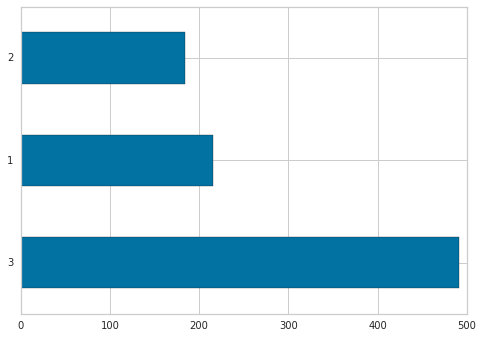

In [13]:
train_df.Pclass.value_counts().plot.barh()

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

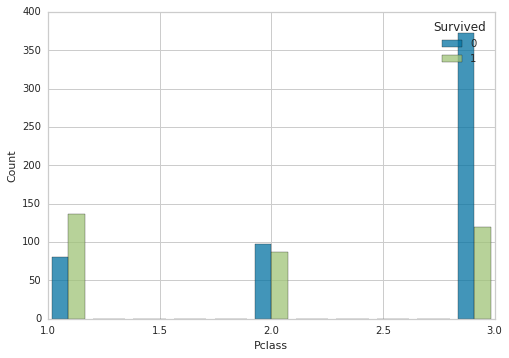

In [14]:
sns.histplot(data=train_df, x=train_df["Pclass"], hue="Survived", multiple="dodge", shrink=.8)

In [15]:
pd.crosstab(train_df["Survived"],train_df["Pclass"])

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


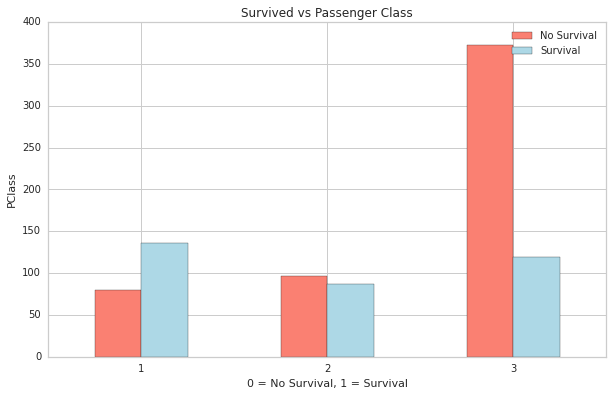

In [16]:
pd.crosstab(train_df["Pclass"],train_df["Survived"]).plot(kind="bar", figsize=(10,6),  color=["salmon", "lightblue"]);
plt.title("Survived vs Passenger Class")
plt.xlabel("0 = No Survival, 1 = Survival")
plt.ylabel("PClass")
plt.legend(["No Survival", "Survival"])
plt.xticks(rotation=0);

#### Sex feature

In [17]:
train_df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

<AxesSubplot:>

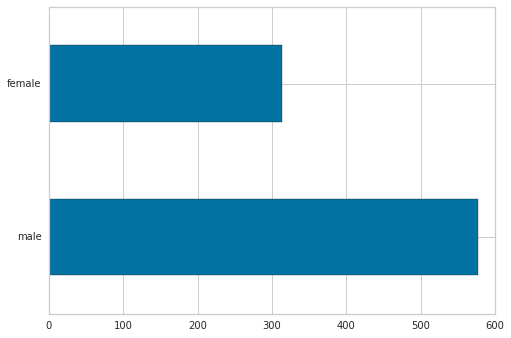

In [18]:
train_df.Sex.value_counts().plot.barh()

<AxesSubplot:xlabel='Sex', ylabel='Count'>

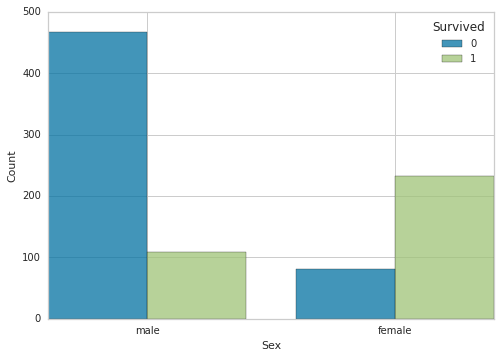

In [19]:
sns.histplot(data=train_df, x=train_df["Sex"], hue="Survived", multiple="dodge", shrink=.8)

In [20]:
pd.crosstab(train_df["Survived"],train_df["Sex"])

Sex,female,male
Survived,,
0,81,468
1,233,109


#### Age

In [21]:
train_df.Age.isnull().sum()

177

In [22]:
train_df.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

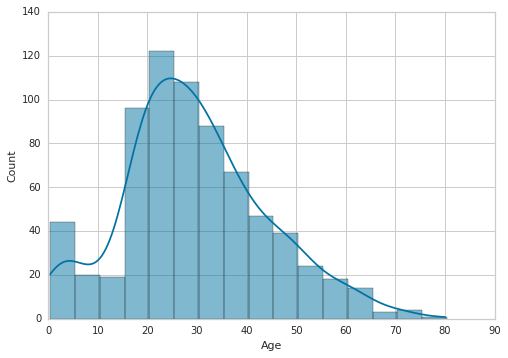

In [23]:
sns.histplot(data=train_df, x=train_df["Age"], binwidth=5 , kde=True)

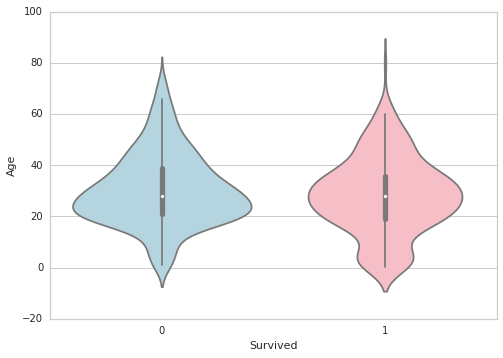

In [24]:
sns.violinplot("Survived", "Age", data=train_df, palette=["lightblue", "lightpink"]);

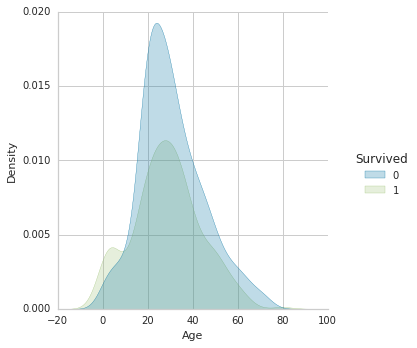

In [25]:
sns.displot(data=train_df, x='Age', hue='Survived', kind='kde', fill=True)

#### SibSp

In [26]:
train_df.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

<AxesSubplot:>

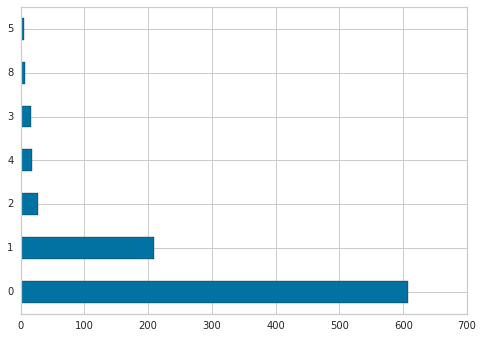

In [27]:
train_df.SibSp.value_counts().plot.barh()

In [28]:
pd.crosstab(train_df["Survived"],train_df["SibSp"])

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,210,112,13,4,3,0,0


#### Parch

In [29]:
train_df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

<AxesSubplot:>

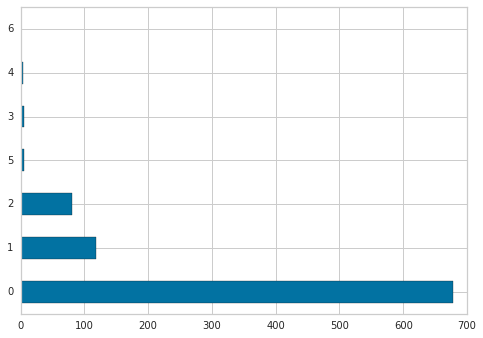

In [30]:
train_df.Parch.value_counts().plot.barh()

In [31]:
pd.crosstab(train_df["Survived"],train_df["Parch"])

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


#### Ticket

In [32]:
train_df.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [33]:
train_df = train_df.drop('Ticket',axis=1)

#### Fare

<AxesSubplot:xlabel='Fare', ylabel='Count'>

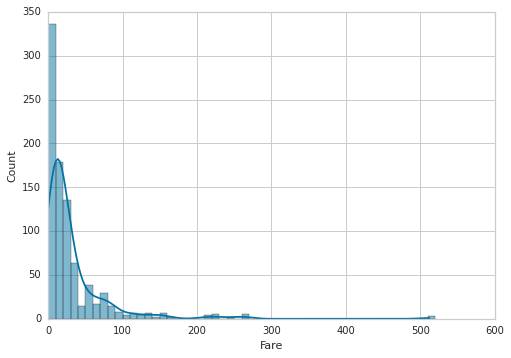

In [34]:
sns.histplot(data=train_df, x=train_df["Fare"], binwidth=10 , kde=True)

In [35]:
LogFare = np.log(train_df.Fare + 1.0) # Adding 1 to accomodate zero fares : log(0) is not defined

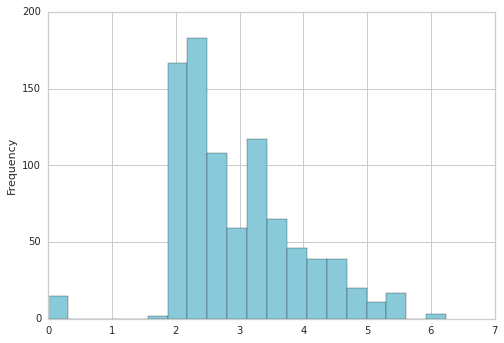

In [36]:
# Histogram of LogFare
LogFare.plot(kind='hist', color='c', bins=20);

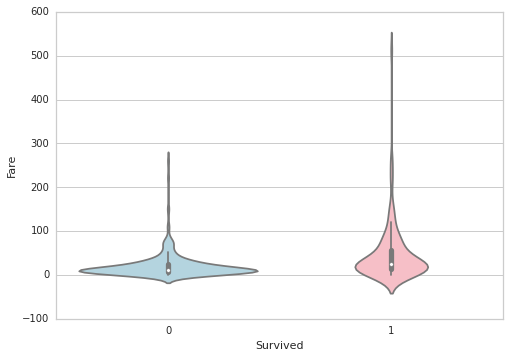

In [37]:
sns.violinplot("Survived", "Fare", data=train_df, palette=["lightblue", "lightpink"]);

<AxesSubplot:>

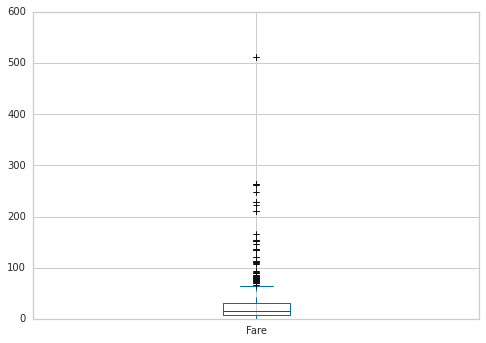

In [38]:
# box-whisker plot
train_df.Fare.plot(kind='box')

#### Cabin

In [39]:
train_df.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [40]:
train_df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

#### Embarked

In [41]:
train_df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:>

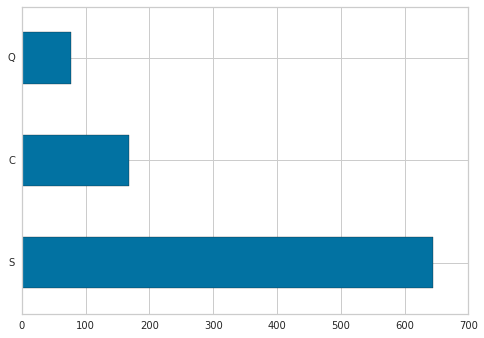

In [42]:
train_df.Embarked.value_counts().plot.barh()

# Feature Selection

In [43]:
# Function to extract the title from the name 
def GetTitle(name):
    first_name_with_title = name.split(',')[1]
    title = first_name_with_title.split('.')[0]
    title = title.strip().lower()
    return title

In [44]:
# use map function to apply the function on each Name value row i
train_df.Name.map(lambda x : GetTitle(x)) 

0        mr
1       mrs
2      miss
3       mrs
4        mr
       ... 
886     rev
887    miss
888    miss
889      mr
890      mr
Name: Name, Length: 891, dtype: object

In [45]:
train_df.Name.map(lambda x : GetTitle(x)).unique()

array(['mr', 'mrs', 'miss', 'master', 'don', 'rev', 'dr', 'mme', 'ms',
       'major', 'lady', 'sir', 'mlle', 'col', 'capt', 'the countess',
       'jonkheer'], dtype=object)

In [46]:
train_df.Name.map(lambda x : GetTitle(x)).unique()

array(['mr', 'mrs', 'miss', 'master', 'don', 'rev', 'dr', 'mme', 'ms',
       'major', 'lady', 'sir', 'mlle', 'col', 'capt', 'the countess',
       'jonkheer'], dtype=object)

In [47]:
# Function to extract the title from the name 
def GetTitle(name):
    title_group = {'mr' : 'Mr', 
               'mrs' : 'Mrs', 
               'miss' : 'Miss', 
               'master' : 'Master',
               'don' : 'Sir',
               'rev' : 'Sir',
               'dr' : 'Officer',
               'mme' : 'Mrs',
               'ms' : 'Mrs',
               'major' : 'Officer',
               'lady' : 'Lady',
               'sir' : 'Sir',
               'mlle' : 'Miss',
               'col' : 'Officer',
               'capt' : 'Officer',
               'the countess' : 'Lady',
               'jonkheer' : 'Sir',
               'dona' : 'Lady'
                 }
    first_name_with_title = name.split(',')[1]
    title = first_name_with_title.split('.')[0]
    title = title.strip().lower()
    return title_group[title]

In [48]:
# create Title feature
train_df['Title'] =  train_df.Name.map(lambda x : GetTitle(x))

In [49]:
# binning
pd.qcut(train_df.Fare, 4)

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
            ...       
886     (7.91, 14.454]
887     (14.454, 31.0]
888     (14.454, 31.0]
889     (14.454, 31.0]
890     (-0.001, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [50]:
pd.qcut(train_df.Fare, 4, labels=['very_low','low','high','very_high']) # discretization

0       very_low
1      very_high
2            low
3      very_high
4            low
         ...    
886          low
887         high
888         high
889         high
890     very_low
Name: Fare, Length: 891, dtype: category
Categories (4, object): ['very_low' < 'low' < 'high' < 'very_high']

In [51]:
# create fare bin feature
train_df['Fare_Bin'] = pd.qcut(train_df.Fare, 4, labels=['very_low','low','high','very_high'])

In [52]:
# AgeState based on Age
train_df['AgeState'] = np.where(train_df['Age'] >= 18, 'Adult','Child')

In [53]:
# AgeState Counts
train_df['AgeState'].value_counts()

Adult    601
Child    290
Name: AgeState, dtype: int64

In [54]:
train_df.groupby(['Pclass']).Fare.median()

Pclass
1    60.2875
2    14.2500
3     8.0500
Name: Fare, dtype: float64

In [55]:
train_df.groupby(['Pclass']).Age.median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [56]:
train_df.groupby(['Pclass'])['Fare','Age'].median()

,Fare,Age
Pclass,,
1,60.2875,37.0
2,14.2500,29.0
3,8.0500,24.0


In [57]:
train_df.groupby(['Pclass']).agg({'Fare' : 'mean', 'Age' : 'median'})

,Fare,Age
Pclass,,
1,84.154687,37.0
2,20.662183,29.0
3,13.675550,24.0


In [58]:
# pivot table
train_df.pivot_table(index='Sex',columns = 'Pclass',values='Age', aggfunc='mean')

Pclass,1,2,3
Sex,,,
female,34.611765,28.722973,21.750000
male,41.281386,30.740707,26.507589


In [59]:
# Family : Adding Parents with Siblings
train_df['FamilySize'] = train_df.Parch + train_df.SibSp + 1 # 1 for self

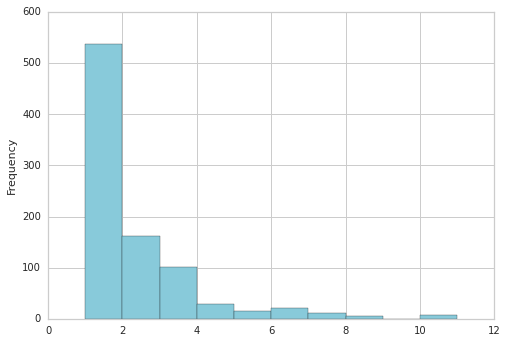

In [60]:
# explore the family feature
train_df['FamilySize'].plot(kind='hist', color='c');

In [61]:
train_df.dtypes

Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin           object
Embarked        object
Title           object
Fare_Bin      category
AgeState        object
FamilySize       int64
dtype: object

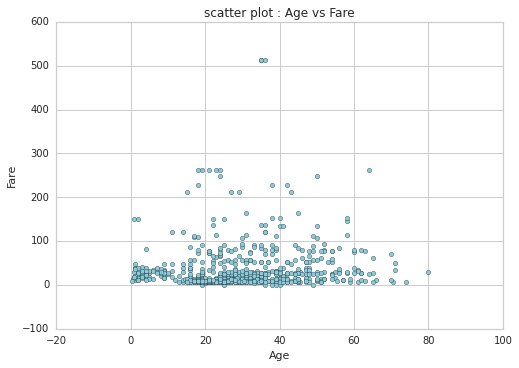

In [62]:
train_df.plot.scatter(x='Age', y='Fare', color='c', title='scatter plot : Age vs Fare');

In [63]:
train_df.pivot_table(index='Sex',columns = 'Pclass',values='Age', aggfunc='mean')

Pclass,1,2,3
Sex,,,
female,34.611765,28.722973,21.750000
male,41.281386,30.740707,26.507589


In [64]:
train_df.dtypes

Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin           object
Embarked        object
Title           object
Fare_Bin      category
AgeState        object
FamilySize       int64
dtype: object

In [65]:
train_df = pd.get_dummies(train_df,columns=['Sex', 'Pclass','Title', 'Fare_Bin', 'Embarked','AgeState'])

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            891 non-null    int64  
 1   Name                891 non-null    object 
 2   Age                 714 non-null    float64
 3   SibSp               891 non-null    int64  
 4   Parch               891 non-null    int64  
 5   Fare                891 non-null    float64
 6   Cabin               204 non-null    object 
 7   FamilySize          891 non-null    int64  
 8   Sex_female          891 non-null    uint8  
 9   Sex_male            891 non-null    uint8  
 10  Pclass_1            891 non-null    uint8  
 11  Pclass_2            891 non-null    uint8  
 12  Pclass_3            891 non-null    uint8  
 13  Title_Lady          891 non-null    uint8  
 14  Title_Master        891 non-null    uint8  
 15  Title_Miss          891 non-null    uint8  
 16  Title_Mr

In [67]:
# drop columns
train_df.drop(['Cabin','Name','Parch','SibSp'], axis=1, inplace=True)

In [68]:
#### the KNN Imptuer is a distance-based imputation method and it requires us to normalize our data. 
imputer = KNNImputer()
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns = train_df.columns)
train_df.head()

,Survived,Age,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Title_Lady,...,Title_Sir,Fare_Bin_very_low,Fare_Bin_low,Fare_Bin_high,Fare_Bin_very_high,Embarked_C,Embarked_Q,Embarked_S,AgeState_Adult,AgeState_Child
0,0.0,0.271174,0.014151,0.1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.472229,0.139136,0.1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.321438,0.015469,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.434531,0.103644,0.1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.434531,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [69]:
train_df.isnull().sum()

Survived                0
Age                   177
Fare                    0
FamilySize              0
Sex_female              0
Sex_male                0
Pclass_1                0
Pclass_2                0
Pclass_3                0
Title_Lady              0
Title_Master            0
Title_Miss              0
Title_Mr                0
Title_Mrs               0
Title_Officer           0
Title_Sir               0
Fare_Bin_very_low       0
Fare_Bin_low            0
Fare_Bin_high           0
Fare_Bin_very_high      0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
AgeState_Adult          0
AgeState_Child          0
dtype: int64

In [70]:
imputer = KNNImputer(n_neighbors=5)
train_df = pd.DataFrame(imputer.fit_transform(train_df),columns = train_df.columns)

In [71]:
train_df.isnull().sum()

Survived              0
Age                   0
Fare                  0
FamilySize            0
Sex_female            0
Sex_male              0
Pclass_1              0
Pclass_2              0
Pclass_3              0
Title_Lady            0
Title_Master          0
Title_Miss            0
Title_Mr              0
Title_Mrs             0
Title_Officer         0
Title_Sir             0
Fare_Bin_very_low     0
Fare_Bin_low          0
Fare_Bin_high         0
Fare_Bin_very_high    0
Embarked_C            0
Embarked_Q            0
Embarked_S            0
AgeState_Adult        0
AgeState_Child        0
dtype: int64

# Model training and evaluation

In [72]:
X = train_df.drop('Survived',axis=1)
y = train_df['Survived']

In [73]:
X.head()

,Age,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Title_Lady,Title_Master,...,Title_Sir,Fare_Bin_very_low,Fare_Bin_low,Fare_Bin_high,Fare_Bin_very_high,Embarked_C,Embarked_Q,Embarked_S,AgeState_Adult,AgeState_Child
0,0.271174,0.014151,0.1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.472229,0.139136,0.1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.321438,0.015469,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.434531,0.103644,0.1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.434531,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [74]:
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 891, dtype: float64

In [75]:
X.shape,y.shape

((891, 24), (891,))

In [76]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=0)


In [77]:
 X_train.shape, y_train.shape,X_test.shape, y_test.shape

((712, 24), (712,), (179, 24), (179,))

In [78]:
# average survival in train and test
print ('mean survival in train : {0:.3f}'.format(np.mean(y_train)))
print ('mean survival in test : {0:.3f}'.format(np.mean(y_test)))

mean survival in train : 0.383
mean survival in test : 0.385


# Logistic Regression

In [79]:
# create model
model = LogisticRegression(random_state=0)

In [80]:
# train model
model.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [81]:
# evaluate model
print ('score for logistic regression - version 1 : {0:.2f}'.format(model.score(X_test, y_test)))

score for logistic regression - version 1 : 0.80


In [82]:
y_pred = model.predict(X_test)

In [83]:
accuracy_score(y_test,y_pred)

0.8044692737430168

In [84]:
confusion_matrix(y_test,y_pred)

array([[98, 12],
       [23, 46]])

In [85]:
precision_score(y_test, y_pred)

0.7931034482758621

In [86]:
recall_score(y_test, y_pred)

0.6666666666666666

In [87]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       110
         1.0       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [88]:
# model coefficients
model.coef_

array([[-1.13395392,  0.45777648, -2.66523095,  0.9494504 , -0.9492984 ,
         0.97152262,  0.05812298, -1.02949359,  0.06669825,  1.82737215,
         0.09046518, -0.88367622,  0.57017876, -0.73368309, -0.93720302,
        -0.13630974, -0.06418859, -0.0447476 ,  0.24539793,  0.09519556,
         0.02111554, -0.22391576,  0.02244391, -0.02229191]])

In [89]:
print(X_train.columns)

Index(['Age', 'Fare', 'FamilySize', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Title_Lady', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Sir',
       'Fare_Bin_very_low', 'Fare_Bin_low', 'Fare_Bin_high',
       'Fare_Bin_very_high', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'AgeState_Adult', 'AgeState_Child'],
      dtype='object')


#### Shows the features ranked according to the explained variance each feature contributes to the model. In this case the features are plotted against their relative importance, that is the percent importance of the most important feature

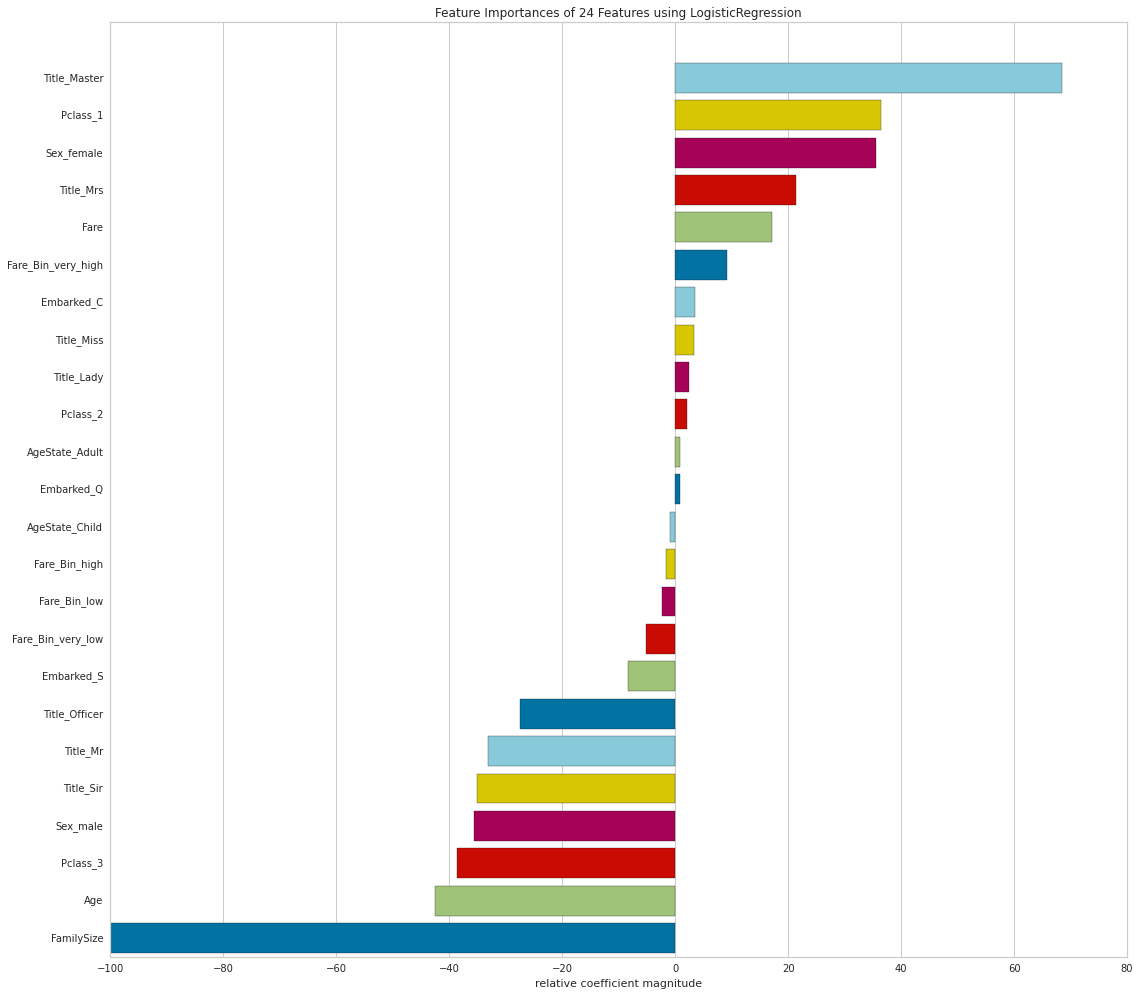

<AxesSubplot:title={'center':'Feature Importances of 24 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [90]:
fig, ax = plt.subplots(figsize=(16, 14))
visualization = FeatureImportances(model)
visualization.fit(X, y)
visualization.poof()

# Stratified Crossvalidation

In [91]:
for model in [LogisticRegression]:
     skflr = model()
     skf = StratifiedKFold(n_splits=10, random_state=42)
     s = cross_val_score(skflr, X, y, scoring="roc_auc", cv=skf)
     print("Accuracy = ", s.mean())

Accuracy =  0.8705175848117026


In [92]:
# Loads test data set
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [93]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [94]:
test.drop(["PassengerId"], axis=1, inplace=True)

In [95]:
test.drop(["Ticket"], axis=1, inplace=True)

In [96]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [97]:
# create Title feature
test['Title'] =  test.Name.map(lambda x : GetTitle(x))

# create fare bin feature
test['Fare_Bin'] = pd.qcut(test.Fare, 4, labels=['very_low','low','high','very_high'])

# AgeState based on Age
test['AgeState'] = np.where(test['Age'] >= 18, 'Adult','Child')

# AgeState Counts
test['AgeState'].value_counts()



Adult    291
Child    127
Name: AgeState, dtype: int64

In [98]:
# Family : Adding Parents with Siblings
test['FamilySize'] = test.Parch + test.SibSp + 1 # 1 for self



In [99]:
test = pd.get_dummies(test,columns=['Sex', 'Pclass','Title', 'Fare_Bin', 'Embarked','AgeState'])

# drop columns
test.drop(['Cabin','Name','Parch','SibSp'], axis=1, inplace=True)

In [100]:

test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)
test.head()


,Age,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Title_Lady,Title_Master,...,Title_Sir,Fare_Bin_very_low,Fare_Bin_low,Fare_Bin_high,Fare_Bin_very_high,Embarked_C,Embarked_Q,Embarked_S,AgeState_Adult,AgeState_Child
0,0.452723,0.015282,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.617566,0.013663,0.1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.815377,0.018909,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.353818,0.016908,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.287881,0.023984,0.2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [101]:
test = pd.DataFrame(imputer.fit_transform(test),columns = test.columns)

test.isnull().sum()


Age                   0
Fare                  0
FamilySize            0
Sex_female            0
Sex_male              0
Pclass_1              0
Pclass_2              0
Pclass_3              0
Title_Lady            0
Title_Master          0
Title_Miss            0
Title_Mr              0
Title_Mrs             0
Title_Officer         0
Title_Sir             0
Fare_Bin_very_low     0
Fare_Bin_low          0
Fare_Bin_high         0
Fare_Bin_very_high    0
Embarked_C            0
Embarked_Q            0
Embarked_S            0
AgeState_Adult        0
AgeState_Child        0
dtype: int64

In [102]:
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [103]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [104]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [105]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state= 40)
val_acc = []
test_predictions = []
submission_predictions = []
model = LogisticRegression(random_state=0)

In [106]:
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    print('Fold', fold )
    
    model.fit(x_train_fold, y_train_fold)
    
    print("score : ",model.score(x_train_fold, y_train_fold))
    
    y_pred = model.predict(x_test_fold)
    print("Validation score : ",accuracy_score(y_test_fold, y_pred))
    
    preds = model.predict(X_test)
    test_predictions.append(preds)
    
    submission_preds = model.predict(test)
    submission_predictions.append(submission_preds)
    

Fold 0
score :  0.83125
Validation score :  0.875
Fold 1
score :  0.840625
Validation score :  0.7777777777777778
Fold 2
score :  0.8471138845553822
Validation score :  0.7323943661971831
Fold 3
score :  0.8346333853354134
Validation score :  0.8309859154929577
Fold 4
score :  0.8377535101404057
Validation score :  0.8450704225352113
Fold 5
score :  0.8268330733229329
Validation score :  0.8591549295774648
Fold 6
score :  0.8330733229329174
Validation score :  0.8450704225352113
Fold 7
score :  0.828393135725429
Validation score :  0.8732394366197183
Fold 8
score :  0.8330733229329174
Validation score :  0.8450704225352113
Fold 9
score :  0.8408736349453978
Validation score :  0.8028169014084507


In [107]:
y_pred = np.mean(np.column_stack(test_predictions), axis=1)

In [108]:
y_pred = y_pred.astype('int32')
y_test = y_test.astype('int32')

In [109]:
print(accuracy_score(y_test, y_pred))

0.8324022346368715


In [110]:
submission_preds = np.mean(np.column_stack(submission_predictions), axis=1)
submission_preds = submission_preds.astype('int32')

In [111]:
submit_df =  pd.DataFrame({'PassengerId': submission['PassengerId'],
                          'Survived': submission_preds})

In [112]:
submit_df.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [113]:
submit_df.to_csv('submission.csv',index=False)

# Naive Bayes

In [114]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [115]:
y_pred = classifier.predict(X_test)

In [116]:
accuracy_score(y_test,y_pred)

0.776536312849162

In [117]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[103   7]
 [ 33  36]]


In [118]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       110
           1       0.84      0.52      0.64        69

    accuracy                           0.78       179
   macro avg       0.80      0.73      0.74       179
weighted avg       0.79      0.78      0.76       179



In [119]:
test_preds = classifier.predict(test)
test_preds = test_preds.astype('int32')

In [120]:
submission["Survived"] = test_preds

In [121]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [122]:
submission.to_csv('submission.csv',index=False) # 0.76794

# KNN

In [123]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)



KNeighborsClassifier()

In [124]:
knc.score(X_test, y_test)


0.8212290502793296

In [125]:
y_pred = knc.predict(X_test)

In [126]:
print(confusion_matrix(y_test,y_pred))

[[101   9]
 [ 23  46]]


In [127]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       110
           1       0.84      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



In [128]:
test_preds = knc.predict(test)
test_preds = test_preds.astype('int32')

In [129]:
submission["Survived"] = test_preds

In [130]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [131]:
submission.to_csv('submission.csv',index=False) # 0.76794

# Linear Discriminant Analysis

In [132]:
# LDA
lda = LDA()
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [133]:
y_pred=lda.predict(X_test)

In [134]:
lda.score(X_test, y_test)

0.8212290502793296

In [135]:
print(confusion_matrix(y_test,y_pred))

[[99 11]
 [21 48]]


In [136]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [137]:
test_preds = lda.predict(test)
test_preds = test_preds.astype('int32')

In [138]:
submission["Survived"] = test_preds

In [139]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [140]:
submission.to_csv('submission.csv',index=False) # 0.77511

#### Tuning LDA Hyperparameters solver and shrinkage with sklearn GridSearchCV

#### An important hyperparameter is the solver, which defaults to ‘svd‘ but can also be set to other values for solvers that support the shrinkage capability.

#### Reading ... https://machinelearningmastery.com/linear-discriminant-analysis-with-python/

In [141]:
# define model
model = LDA()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.829
Config: {'solver': 'svd'}


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 468, in fit
    self._solve_eigen(X, y, shrinkage=self.shrinkage)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 335, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/opt/conda/lib/python3.7/site-packages/scipy/linalg/decomp.py", line 581, in eigh
    'or eigenvectors were computed.'.format(info-n))
numpy.linalg.LinAlgError: The leading minor of order 24 of B is not positive definite. The factorization of B could not be completed and no eig

In [142]:
# define model
model =LDA(solver='lsqr')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['shrinkage'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.828
Config: {'shrinkage': 0.01}


# Support Vector Machine 

#### The linear kernel

In [143]:
svm_model = svm.SVC(kernel='linear', class_weight='balanced') 
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [144]:
y_pred=svm_model.predict(X_test)

In [145]:
accuracy_score(y_test,y_pred)

0.7988826815642458

In [146]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[95 15]
 [21 48]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



In [147]:
test_preds = svm_model.predict(test)
test_preds = test_preds.astype('int32')

In [148]:
submission["Survived"] = test_preds
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [149]:
submission.to_csv('submission.csv',index=False) # 0.77033

#### Polynomial Kernel can distinguish curved or nonlinear input space.
#### SVM classifier using a third-degree polynomial kernel. the hyperparameter coef0 controls how much the model is influenced by high degree polynomials versus low degree polynomials

In [150]:
# SVM Classifier model
svm_model = svm.SVC(kernel="poly", degree=3, coef0=1, C=5,class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=5, class_weight='balanced', coef0=1, kernel='poly')

In [151]:
y_pred=svm_model.predict(X_test)

In [152]:
accuracy_score(y_test,y_pred)

0.8044692737430168

In [153]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[92 18]
 [17 52]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       110
           1       0.74      0.75      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179



In [154]:
test_preds = svm_model.predict(test)
test_preds = test_preds.astype('int32')

In [155]:
submission["Survived"] = test_preds
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [156]:
submission.to_csv('submission.csv',index=False) # 0.73444

In [157]:
# SVM Classifier model with RBF kernel for non linear separability
svm_model = svm.SVC(kernel="rbf",class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced')

In [158]:
y_pred=svm_model.predict(X_test)

In [159]:
accuracy_score(y_test,y_pred)

0.8100558659217877

In [160]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[95 15]
 [19 50]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [161]:
test_preds = svm_model.predict(test)
test_preds = test_preds.astype('int32')

In [162]:
submission["Survived"] = test_preds
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [163]:
submission.to_csv('submission.csv',index=False) #0.75598

# Hyperparameter tuning with RandomSearch

#### We can use a random search cross-validation to explore combinations of parameters. 


a) Kernel: The main function of the kernel is to transform the given dataset input data into the required form. There are various types of functions such as linear, polynomial, and radial basis function (RBF). Polynomial and RBF are useful for non-linear hyperplane. Polynomial and RBF kernels compute the separation line in the higher dimension. 

b) Regularization: C is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimization how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.

c) Gamma: A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting

d) degree: It is the degree of the polynomial kernel function (‘poly’) default value is 3.

In [164]:

params = { 'C':[0.1,1,10,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}


In [165]:
svm_model = svm.SVC()

In [166]:
random_search = RandomizedSearchCV(svm_model, params, n_iter =10, cv=9)

In [167]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=9, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'degree': [1, 2, 3, 4, 5, 6],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'poly', 'sigmoid',
                                                   'linear']})

In [168]:
random_search.best_params_

{'kernel': 'linear', 'gamma': 1, 'degree': 1, 'C': 100}

In [169]:

random_search.best_score_

0.8385021097046415

#### training the model with the selectec parameters

In [170]:
svm_model = svm.SVC(kernel="poly",gamma=1,degree=1,C=10,class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', degree=1, gamma=1, kernel='poly')

In [171]:
y_pred=svm_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.8100558659217877

In [172]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[97 13]
 [21 48]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [173]:
test_preds = svm_model.predict(test)
test_preds = test_preds.astype('int32')
submission["Survived"] = test_preds
submission
submission.to_csv('submission.csv',index=False) # 0.77033

# RandomForest

In [174]:
# with the default hyperparameters setting
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


RandomForestClassifier()

In [175]:
y_pred = rf_model.predict(X_test)

In [176]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[98 12]
 [25 44]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179



# Hyperparameter tuning with Optuna

#### the objective function

In [177]:
# the objective function takes the hyperparameter space as input
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy'])
    max_depth = trial.suggest_int("max_depth", 1, 4)
    min_samples_split = trial.suggest_float("min_samples_split", 0.01, 1)

    model = RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
        )
    
    score = cross_val_score(model, X_train, y_train, cv=5)
    accuracy = score.mean()
    
    return accuracy
    

In [178]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2021-12-01 22:24:41,450] A new study created in memory with name: no-name-1a7cb041-4ce5-4027-8b2c-4c676c43dfaa
[I 2021-12-01 22:24:49,952] Trial 0 finished with value: 0.7892642568698908 and parameters: {'n_estimators': 979, 'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 0.16097579143495794}. Best is trial 0 with value: 0.7892642568698908.
[I 2021-12-01 22:24:58,117] Trial 1 finished with value: 0.7892642568698908 and parameters: {'n_estimators': 954, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 0.4231215731686448}. Best is trial 0 with value: 0.7892642568698908.
[I 2021-12-01 22:24:59,477] Trial 2 finished with value: 0.6165763813651137 and parameters: {'n_estimators': 161, 'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 0.6715080437889249}. Best is trial 0 with value: 0.7892642568698908.
[I 2021-12-01 22:25:04,019] Trial 3 finished with value: 0.7962671131685217 and parameters: {'n_estimators': 476, 'criterion': 'entropy', 'max_depth': 4,

In [179]:
study.best_params

{'n_estimators': 748,
 'criterion': 'gini',
 'max_depth': 4,
 'min_samples_split': 0.01881529461416155}

In [180]:
study.best_value

0.8257854821235103

In [181]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_split,params_n_estimators,state
0,0,0.789264,2021-12-01 22:24:41.454037,2021-12-01 22:24:49.952168,0 days 00:00:08.498131,entropy,1,0.160976,979,COMPLETE
1,1,0.789264,2021-12-01 22:24:49.953649,2021-12-01 22:24:58.117429,0 days 00:00:08.163780,entropy,3,0.423122,954,COMPLETE
2,2,0.616576,2021-12-01 22:24:58.119154,2021-12-01 22:24:59.476893,0 days 00:00:01.357739,entropy,1,0.671508,161,COMPLETE
3,3,0.796267,2021-12-01 22:24:59.478271,2021-12-01 22:25:04.018861,0 days 00:00:04.540590,entropy,4,0.157038,476,COMPLETE
4,4,0.793440,2021-12-01 22:25:04.020270,2021-12-01 22:25:05.142354,0 days 00:00:01.122084,gini,3,0.274279,104,COMPLETE
5,5,0.790663,2021-12-01 22:25:05.143800,2021-12-01 22:25:06.164492,0 days 00:00:01.020692,gini,2,0.043599,120,COMPLETE
6,6,0.789264,2021-12-01 22:25:06.165808,2021-12-01 22:25:09.231460,0 days 00:00:03.065652,entropy,3,0.437967,366,COMPLETE
7,7,0.789264,2021-12-01 22:25:09.232880,2021-12-01 22:25:13.669043,0 days 00:00:04.436163,gini,1,0.321924,540,COMPLETE
8,8,0.814557,2021-12-01 22:25:13.670866,2021-12-01 22:25:19.943895,0 days 00:00:06.273029,entropy,3,0.039432,684,COMPLETE
9,9,0.825766,2021-12-01 22:25:19.945302,2021-12-01 22:25:24.362836,0 days 00:00:04.417534,gini,4,0.072496,514,COMPLETE


In [182]:
# training the model with the hyperparameter values
model = RandomForestClassifier(
            n_estimators=214,
            criterion='gini',
            max_depth=4,
            min_samples_split=0.31977425965640455,
        )
    
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, min_samples_split=0.31977425965640455,
                       n_estimators=214)

In [183]:
y_pred = model.predict(X_test)

In [184]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[93 17]
 [22 47]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       110
           1       0.73      0.68      0.71        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



#### Feature importances

In [185]:
importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

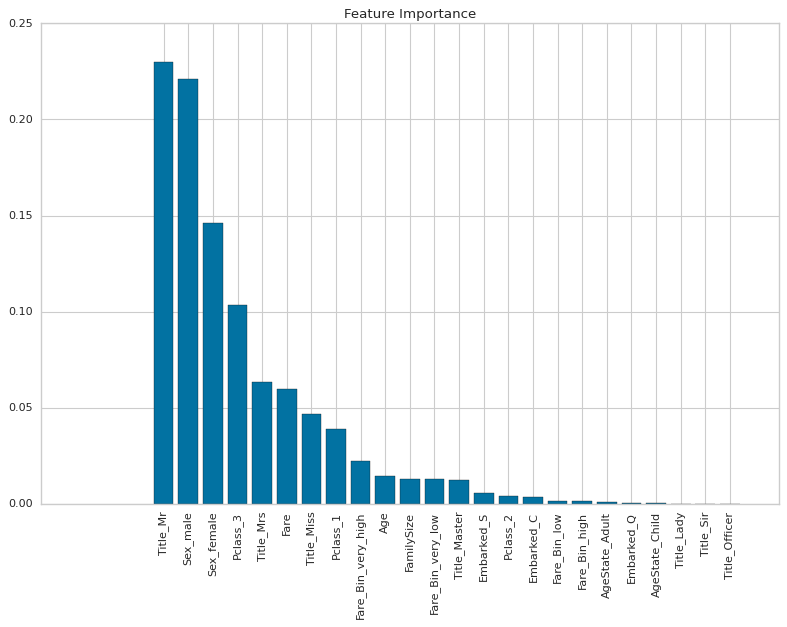

In [186]:
plt.figure(figsize=(10,8), dpi=80)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [187]:
test_preds = model.predict(test)
test_preds = test_preds.astype('int32')
submission["Survived"] = test_preds
submission
submission.to_csv('submission.csv',index=False) #0.77

# XGBoost

In [188]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state= 40)

In [189]:
# Performs cross validation on XGB Classifier

model = XGBClassifier(n_estimators=500,objective='binary:logistic', eval_metric='auc',tree_method='gpu_hist')
model_score = cross_val_score(model, X, y, scoring='roc_auc', cv=skf.split(X, y), n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 468, in fit
    self._solve_eigen(X, y, shrinkage=self.shrinkage)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 335, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/opt/conda/lib/python3.7/site-packages/scipy/linalg/decomp.py", line 581, in eigh
    'or eigenvectors were computed.'.format(info-n))
numpy

[CV]  ................................................................
[CV] .................................... , score=0.883, total=   6.2s
[CV]  ................................................................
[CV] .................................... , score=0.871, total=   6.2s


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 468, in fit
    self._solve_eigen(X, y, shrinkage=self.shrinkage)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 335, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/opt/conda/lib/python3.7/site-packages/scipy/linalg/decomp.py", line 581, in eigh
    'or eigenvectors were computed.'.format(info-n))
numpy.linalg.LinAlgError: The leading minor of order 5 of B is not positive definite. The factorization of B could not be completed and no eige

In [190]:
print(model_score.mean())


0.8724570347412272


In [191]:
del model_score, model

## Tuning with Hyperopt

In [192]:
fold_no = 1
for train_index, test_index in skf.split(X, y):
    print('Fold = ',fold_no)
    y_val = y.iloc[test_index]
    dtrain = xgb.DMatrix(data=X.iloc[train_index], label=y.iloc[train_index])
    dval = xgb.DMatrix(data=X.iloc[test_index], label=y.iloc[test_index])
    fold_no +=1

Fold =  1
Fold =  2
Fold =  3
Fold =  4
Fold =  5


In [193]:
hyperparameter_space = { 
                        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
                        'max_depth': hp.quniform("max_depth", 2, 6, 1),
                        'min_child_weight' : hp.quniform('min_child_weight', 1, 8, 1),
                        'reg_alpha' : hp.uniform('reg_alpha', 1e-8, 100),
                        'reg_lambda' : hp.uniform('reg_lambda', 1e-8, 100),
                        'gamma': hp.uniform ('gamma', 0.0, 1.0),
                        'subsample': hp.uniform("subsample", 0.1, 1.0),
                        'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0)
                       }

In [194]:
def optimize_hyppara(hyperparameter_space):
    # Converts parameter value to int as required by XGBoost
    hyperparameter_space["max_depth"] = int(hyperparameter_space["max_depth"])
    hyperparameter_space["objective"] = "binary:logistic"
    hyperparameter_space["eval_metric"] = "auc"
    hyperparameter_space["tree_method"] = "gpu_hist"
    
    model = xgb.train(
        hyperparameter_space, 
        dtrain, 
        num_boost_round=2000, 
        evals=[(dtrain, 'train'), (dval, 'eval')],
        early_stopping_rounds=50, verbose_eval=False)
    
    predictions = model.predict(dval)
    
    roc_auc = roc_auc_score(y_val, predictions)
    
    del predictions, model, hyperparameter_space
    
    return {"loss": -roc_auc, "status": STATUS_OK}

In [195]:
# Starts hyperparameters tuning
trials = Trials()
best_model_params = fmin(fn=optimize_hyppara,space=hyperparameter_space, max_evals=50,algo=tpe.suggest,trials=trials)

100%|██████████| 50/50 [00:07<00:00,  6.46trial/s, best loss: -0.886451269777955]


In [196]:
best_model_params

{'colsample_bytree': 0.6853116883637241,
 'gamma': 0.4893641151991309,
 'learning_rate': 0.29919204121627896,
 'max_depth': 6.0,
 'min_child_weight': 3.0,
 'reg_alpha': 0.6490794464791652,
 'reg_lambda': 70.8008039860882,
 'subsample': 0.9860089796727436}

In [197]:
del dtrain, dval,y_val

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_test, label=y_test)
#del X_train,y_train,X_test,y_test
params = {'colsample_bytree': 0.9912835539334705,
 'gamma': 0.9947467688258089,
 'learning_rate': 0.17756388494635836,
 'max_depth': 6.0,
 'min_child_weight': 4.0,
 'reg_alpha': 1.0806687020657577,
 'reg_lambda': 56.99895595690155,
 'subsample': 0.7218949376758498}

params["max_depth"] = int(params["max_depth"])
params["objective"] = "binary:logistic"
params["eval_metric"] = "auc"
params["tree_method"] = "gpu_hist"
    
model = xgb.train(
        params, 
        dtrain, 
        num_boost_round=2000, 
        evals=[(dtrain, 'train'), (dval, 'eval')],
        early_stopping_rounds=50, verbose_eval=200)

[0]	train-auc:0.81294	eval-auc:0.82807
[95]	train-auc:0.87783	eval-auc:0.89656


In [199]:
# Adds other important parameters
best_model_params["max_depth"] = int(best_model_params["max_depth"])
best_model_params["objective"] = "binary:logistic"
best_model_params["eval_metric"] = "auc"
best_model_params["tree_method"] = "gpu_hist"

In [200]:
dtest = xgb.DMatrix(data=test)
predictions = model.predict(dtest)

In [201]:
predictions  = predictions > 0.5  
predictions = predictions.astype(int)  

In [202]:
submission["Survived"] = predictions
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [203]:
submission.to_csv("./submission.csv", index=False) # 0.78468

In [204]:
del model, dtest, predictions

In [205]:
# Gets the model trained over cross validation and predictions 
# against each iteration is stored

test_predictions = []

dtest = xgb.DMatrix(data=test)

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print("fold", fold)

    dtrain = xgb.DMatrix(data=X.iloc[train_index], label=y.iloc[train_index])
    dval = xgb.DMatrix(data=X.iloc[val_index], label=y.iloc[val_index])
    
    model = xgb.train(
        best_model_params, 
        dtrain, 
        num_boost_round=2000, 
        evals=[(dtrain, 'train'), (dval, 'eval')],
        early_stopping_rounds=50, verbose_eval=200)
    
    predictions = model.predict(dtest)
    
    test_predictions.append(predictions)
    
    del predictions, model, dval, dtrain

fold 0
[0]	train-auc:0.82034	eval-auc:0.84743
[72]	train-auc:0.88452	eval-auc:0.92260
fold 1
[0]	train-auc:0.80595	eval-auc:0.81310
[57]	train-auc:0.89667	eval-auc:0.85869
fold 2
[0]	train-auc:0.81549	eval-auc:0.77580
[124]	train-auc:0.89367	eval-auc:0.86464
fold 3
[0]	train-auc:0.84807	eval-auc:0.81190
[97]	train-auc:0.89436	eval-auc:0.84686
fold 4
[0]	train-auc:0.83166	eval-auc:0.82303
[97]	train-auc:0.89279	eval-auc:0.88645


In [206]:
del dtest

In [207]:
submission_preds = np.mean(np.column_stack(submission_predictions), axis=1)
submission_preds  = submission_preds > 0.5  
submission_preds = submission_preds.astype(int)  

In [208]:
submission["Survived"] = submission_preds
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [209]:
submission.to_csv("./submission.csv", index=False) # 0.78468

# Classification with Keras Sequential API

In [210]:
X_train.shape # 24 features hence we start with the first dense model having 24 neurons 

(712, 24)

In [211]:
keras_model = Sequential()
keras_model.add(Dense(units=24,activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(units=12,activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(units=1,activation='sigmoid'))
# For a binary classification problem
keras_model.compile(loss='binary_crossentropy', optimizer='adam')

2021-12-01 22:27:01.015767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 22:27:01.017018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 22:27:01.017674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 22:27:01.019306: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [212]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [213]:
keras_model.fit(x=X_train, 
          y=y_train, 
          epochs=500,
          validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop]
          )

2021-12-01 22:27:04.422573: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
23/23 [==============================] - 2s 11ms/step - loss: 0.7362 - val_loss: 0.6684
Epoch 2/500
23/23 [==============================] - 0s 4ms/step - loss: 0.7117 - val_loss: 0.6504
Epoch 3/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6832 - val_loss: 0.6361
Epoch 4/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6573 - val_loss: 0.6239
Epoch 5/500
23/23 [==============================] - 0s 3ms/step - loss: 0.6336 - val_loss: 0.6153
Epoch 6/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6356 - val_loss: 0.6017
Epoch 7/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6289 - val_loss: 0.5849
Epoch 8/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6343 - val_loss: 0.5701
Epoch 9/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6136 - val_loss: 0.5557
Epoch 10/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6051 - val_loss: 0.5441
Epoch 11

In [214]:
model_loss = pd.DataFrame(keras_model.history.history)

<AxesSubplot:>

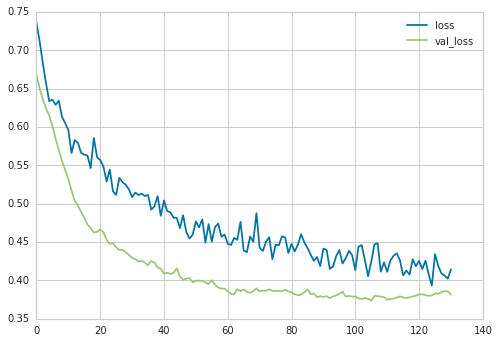

In [215]:
model_loss.plot()

In [216]:
predictions = keras_model.predict(X_test)

In [217]:
predictions  = predictions > 0.5  
predictions = predictions.astype(int)  

In [218]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.88       114
         1.0       0.81      0.72      0.76        65

    accuracy                           0.84       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.84      0.84      0.84       179



In [219]:
test_preds = keras_model.predict(test)

In [220]:
test_preds  = test_preds > 0.5  
test_preds = test_preds.astype(int)  

In [221]:
submission["Survived"] = test_preds
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [222]:
submission.to_csv("./submission.csv", index=False) # 0.77751

# Ensembling and Stacking

In [223]:
# logistic regression, random forest and xgboost
logreg = LogisticRegression()
rf = RandomForestClassifier()
xgbc = XGBClassifier()

In [224]:
# fit all models on X_train
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgbc.fit(X_train, y_train)

[22:27:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [225]:
# predicting all the models on X_test
# taking the probability for class 1
pred_logreg = logreg.predict_proba(X_test)[:, 1]
pred_rf = rf.predict_proba(X_test)[:, 1]
pred_xgbc = xgbc.predict_proba(X_test)[:, 1]


In [226]:
# creating an average of all the predictions
avg_pred = (pred_logreg + pred_rf + pred_xgbc) / 3

In [227]:
# storing all the predictions in an array
test_preds = np.column_stack((
 pred_logreg,
 pred_rf,
 pred_xgbc,
 avg_pred
))

In [228]:
# calculating and storing individual AUC values
auc_test = []
for i in range(test_preds.shape[1]):
 auc = roc_auc_score(y_test, test_preds[:, i])
 auc_test.append(auc)
print(f"LR AUC = {auc_test[0]}")
print(f"RF AUC = {auc_test[1]}")
print(f"XGB AUC = {auc_test[2]}")
print(f"Average Pred AUC = {auc_test[3]}")

LR AUC = 0.8914979757085021
RF AUC = 0.900067476383266
XGB AUC = 0.9097165991902834
Average Pred AUC = 0.9175438596491228


In [229]:
# predict all models on test
# take probability for class 1
pred_logreg = logreg.predict_proba(test)[:, 1]
pred_rf = rf.predict_proba(test)[:, 1]
pred_xgbc = xgbc.predict_proba(test)[:, 1]

In [230]:
# create an average of all predictions
# that is the simplest ensemble
test_preds = (pred_logreg + pred_rf + pred_xgbc) / 3

In [231]:
test_preds

array([0.06879712, 0.30882712, 0.15821394, 0.09199681, 0.7734001 ,
       0.08918387, 0.3172331 , 0.07934946, 0.84798165, 0.02651806,
       0.02680795, 0.24262744, 0.98196705, 0.05303261, 0.97075277,
       0.96028087, 0.08891438, 0.4773751 , 0.49639956, 0.39839954,
       0.26248862, 0.62430663, 0.97249026, 0.67358786, 0.94318945,
       0.02758067, 0.98015004, 0.20737269, 0.37633071, 0.44577091,
       0.06546663, 0.09983845, 0.79329294, 0.50455627, 0.59683684,
       0.545212  , 0.35382366, 0.22316897, 0.06502987, 0.45668427,
       0.07080022, 0.66503351, 0.07255132, 0.95125412, 0.97283135,
       0.18480305, 0.34484033, 0.30460729, 0.97805964, 0.52983757,
       0.37633747, 0.26461169, 0.86125823, 0.93036883, 0.13260367,
       0.1629112 , 0.02992704, 0.1286917 , 0.05919291, 0.98068304,
       0.14263532, 0.23258361, 0.10420995, 0.64233791, 0.79959783,
       0.93692492, 0.79998185, 0.14855565, 0.59750909, 0.88231161,
       0.5003882 , 0.03501417, 0.64223764, 0.48576925, 0.98068

In [232]:
test_preds  = test_preds > 0.5  
test_preds = test_preds.astype(int)  

In [233]:
test_preds

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [234]:
submission["Survived"] = test_preds
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [235]:
submission.to_csv("./submission.csv", index=False) # 0.76315